In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Flat Domain adaptation, one dataset is held out, the model is trained on the remaining four datasets. Prediction is done using the parameters of the dataset that is closest to the held out one.

In [2]:
TRAIN_DIRECTORY = "../../../Data/Symptoms_Demo/Train/"
TEST_DIRECTORY = "../../../Data/Symptoms_Demo/Test/"
coefficients = defaultdict()

In [3]:
def read_file(filename):
    return pd.read_csv(filename)

In [4]:
def get_training_data(files_):
    data = defaultdict()
    columns = defaultdict()
    for i in files_:
        name = i
        name = name.replace('.csv','')
        data[name] = read_file(TRAIN_DIRECTORY+i)
        columns[name] = list(data[name].columns)
        columns[name].remove('virus')
    return data,columns

In [5]:
def overlap_columns(columns_):
    all_columns = list(columns_.values())
    overlap = list(set(all_columns[0]) & set(all_columns[1]) & set(all_columns[2]) & set(all_columns[3]))
    return overlap
    

In [6]:
def create_columns(columns_):
    overlap = overlap_columns(columns_)
    new_columns = []
    temp = []
    for i in columns_.keys():
        x = [i.replace('.csv','')+'_'+j for j in columns_[i]]
        temp.append(x)
    t = [val for sublist in temp for val in sublist]
    new_columns = t + overlap
    new_columns.append('virus')
    return new_columns

In [7]:
def create_new_dataframe(data,columns):
    new_columns = create_columns(columns)
    new_dataset = defaultdict()
    for i,name in enumerate(data.keys()):
        new_data = pd.DataFrame(columns=new_columns)
        dataset = data[name]
        for j in columns[name]:
            new_data[name+'_'+j] = dataset[j]
            new_data[j] = dataset[j]
        new_data['virus'] = dataset['virus']
        new_data.fillna(0,inplace=True)
        new_dataset[name] = new_data
    #concatenate all the dataframe
    new_dataset = pd.concat(new_dataset.values())
    return new_dataset

In [8]:
def ml_model(dataset):
    lm = linear_model.LogisticRegression()
    x_train = dataset.drop(['virus'],axis = 1)
    y_train = dataset['virus']
    x = lm.fit(x_train,y_train)
    coeff = x.coef_.tolist()[0]
    return lm,coeff

#### Heldout dataset : NYUMC

In [53]:
# files_nyumc = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
# data_nyumc,columns_nyumc = get_training_data(files_nyumc)

# #create the dataframe for domain adaptation
# new_dataset_nyumc = create_new_dataframe(data_nyumc,columns_nyumc)

# coeff_without_nyumc = ml_model(new_dataset_nyumc)
# coefficients['nyumc'] = coeff_without_nyumc

#### Heldout dataset : Goviral

In [9]:
files_goviral = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_goviral,columns_goviral = get_training_data(files_goviral)
new_dataset_goviral = create_new_dataframe(data_goviral,columns_goviral)

coeff_without_goviral = ml_model(new_dataset_goviral)
coefficients['goviral'] = coeff_without_goviral

#### Heldout dataset : FluWatch

In [10]:
files_fluwatch = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_fluwatch,columns_fluwatch = get_training_data(files_fluwatch)
new_dataset_fluwatch = create_new_dataframe(data_fluwatch,columns_fluwatch)

coeff_without_fluwatch = ml_model(new_dataset_fluwatch)
coefficients['fluwatch'] = coeff_without_fluwatch

#### Heldout dataset : HongKong

In [11]:
files_hongkong = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_hongkong,columns_hongkong = get_training_data(files_hongkong)
new_dataset_hongkong = create_new_dataframe(data_hongkong,columns_hongkong)

coeff_without_hongkong = ml_model(new_dataset_hongkong)
coefficients['hongkong'] = coeff_without_hongkong

#### Heldout dataset : Hutterite

In [12]:
files_hutterite = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_hutterite,columns_hutterite = get_training_data(files_hutterite)
new_dataset_hutterite = create_new_dataframe(data_hutterite,columns_hutterite)

coeff_without_hutterite = ml_model(new_dataset_hutterite)
coefficients['hutterite'] = coeff_without_hutterite

In [13]:
# remove the target variable
def remove_target(data_dict):
    for i in data_dict.keys():
        data_dict[i].drop(['virus'],axis = 1,inplace = True)
    return data_dict

In [14]:
#get the entire training data
files_ = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_,columns_ = get_training_data(files_)
print(data_.keys())
data_ = remove_target(data_)

dict_keys(['goviral', 'hongkong', 'fluwatch', 'hutterite'])


#### Get the statistical measure of the dataset:

In [15]:
def get_statistical_measure(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data_stats[i] = data_dict[i].var(axis = 0)
    return data_stats

In [16]:
data_stats = get_statistical_measure(data_)

In [17]:
#l2 distance
def get_distance(data_stats):

    distance = defaultdict()
    names = list(data_stats)
    for i in names:
        compare_to = [j for j in names if j!=i]
        distance[i] = [(j,np.linalg.norm((np.asarray(data_stats[i]) - np.asarray(data_stats[j])),ord = 2)) for j in compare_to]
    return distance


In [18]:
distance = get_distance(data_stats)


#### Model for testing the performance

In [19]:
def test_model(train_data,test_data):
    lm,coeff = ml_model(train_data)
    train = test_data.drop(['virus'],axis = 1)
    test = test_data['virus']
    y_pred = lm.predict(train)
    acc = accuracy_score(test,y_pred)
    fpr,tpr,threshold = roc_curve(test,y_pred)
    auc_score = metrics.auc(fpr,tpr)
    return acc,auc_score
    

#### Prepare data for testing

In [20]:
data_,columns = get_training_data(files_)

In [21]:
def create_data_for_testing(data,name,columns_):
    new_data = pd.DataFrame(columns = columns_)
    columns_for_data = list(data.columns)
    col = [x for x in columns_for_data if x != 'virus']
    for i in col:
        new_data[name+'_'+i] = data[i]
        new_data[i] = data[i]
    new_data['virus'] = data['virus']
    new_data.fillna(0,inplace = True)
    return new_data

In [22]:
def test_against_all(dataset_name,to_be_tested_names,data_,original_data,store_):
    columns = list(original_data.columns)
    data = data_[dataset_name]
    for i in to_be_tested_names:
        temp_data = create_data_for_testing(data,i,columns)
        acc,auc_score = test_model(original_data,temp_data)
        print("Comparing against ",i)
        print("Accuracy : ",acc)
        print("Auc Score : ",auc_score)
        print("____________________________")
        store_[i] = auc_score
    return store_

#### Test NYUMC

In [68]:
store_nyumc = defaultdict()
print("Testing NYUMC Data!\n")
store_nyumc = test_against_all('nyumc',['goviral','fluwatch','hongkong','hutterite'],data_,new_dataset_nyumc,store_nyumc)

Testing NYUMC Data!

Comparing against  goviral
Accuracy :  0.909846167892
Auc Score :  0.499874605006
____________________________
Comparing against  fluwatch
Accuracy :  0.910074405441
Auc Score :  0.5
____________________________
Comparing against  hongkong
Accuracy :  0.371296845757
Auc Score :  0.635373787838
____________________________
Comparing against  hutterite
Accuracy :  0.980325923221
Auc Score :  0.920115062956
____________________________


In [69]:
store_nyumc

defaultdict(None,
            {'fluwatch': 0.5,
             'goviral': 0.49987460500576819,
             'hongkong': 0.63537378783778031,
             'hutterite': 0.92011506295592527})

#### Test Goviral

In [23]:
store_gv = defaultdict()
print("Testing Goviral data!\n")
store_gv = test_against_all('goviral',['goviral','fluwatch','hongkong','hutterite'],data_,new_dataset_goviral,store_gv)

Testing Goviral data!

Comparing against  goviral
Accuracy :  0.8296703296703297
Auc Score :  0.8237065257465896
____________________________
Comparing against  fluwatch
Accuracy :  0.6043956043956044
Auc Score :  0.6357379869730859
____________________________
Comparing against  hongkong
Accuracy :  0.728021978021978
Auc Score :  0.7162037605997297
____________________________
Comparing against  hutterite
Accuracy :  0.782967032967033
Auc Score :  0.7617979599360944
____________________________


In [24]:
store_gv

defaultdict(None,
            {'fluwatch': 0.6357379869730859,
             'goviral': 0.8237065257465896,
             'hongkong': 0.7162037605997297,
             'hutterite': 0.7617979599360944})

#### Test Fluwatch

In [25]:
store_fw = defaultdict()
print("Testing FluWatch data!\n")
store_fw = test_against_all('fluwatch',['fluwatch','goviral','hongkong','hutterite'],data_,new_dataset_fluwatch,store_fw)

Testing FluWatch data!

Comparing against  fluwatch
Accuracy :  0.771875
Auc Score :  0.7369155257039524
____________________________
Comparing against  goviral
Accuracy :  0.6171875
Auc Score :  0.5627744768793593
____________________________
Comparing against  hongkong
Accuracy :  0.5234375
Auc Score :  0.4612503229139757
____________________________
Comparing against  hutterite
Accuracy :  0.625
Auc Score :  0.5574786876776027
____________________________


In [73]:
store_fw

defaultdict(None,
            {'goviral': 0.52773976768229636,
             'hongkong': 0.47783251231527102,
             'hutterite': 0.57030347260232317,
             'nyumc': 0.57891656023839921})

#### Test Hongkong

In [26]:
store_hk = defaultdict()
print("Testing Hongkong!\n")
store_hk = test_against_all('hongkong',['hongkong','goviral','fluwatch','hutterite'],data_,new_dataset_hongkong,store_hk)

Testing Hongkong!

Comparing against  hongkong
Accuracy :  0.9824106113033448
Auc Score :  0.9789386953209575
____________________________
Comparing against  goviral
Accuracy :  0.9463667820069204
Auc Score :  0.9270173609718937
____________________________
Comparing against  fluwatch
Accuracy :  0.8526528258362168
Auc Score :  0.8431791026823302
____________________________
Comparing against  hutterite
Accuracy :  0.9140715109573241
Auc Score :  0.9208107132833486
____________________________


In [27]:
store_hk

defaultdict(None,
            {'fluwatch': 0.8431791026823302,
             'goviral': 0.9270173609718937,
             'hongkong': 0.9789386953209575,
             'hutterite': 0.9208107132833486})

#### Test hutterite

In [28]:
store_ht = defaultdict()
print("Testing hutterite!\n")
store_ht = test_against_all('hutterite',['hutterite','goviral','fluwatch','hongkong'],data_,new_dataset_hutterite,store_ht)

Testing hutterite!

Comparing against  hutterite
Accuracy :  0.7591973244147158
Auc Score :  0.7359462345330068
____________________________
Comparing against  goviral
Accuracy :  0.7157190635451505
Auc Score :  0.7009531436467558
____________________________
Comparing against  fluwatch
Accuracy :  0.6755852842809364
Auc Score :  0.6755307455561838
____________________________
Comparing against  hongkong
Accuracy :  0.7246376811594203
Auc Score :  0.7003485961937064
____________________________


In [29]:
store_ht

defaultdict(None,
            {'fluwatch': 0.6755307455561838,
             'goviral': 0.7009531436467558,
             'hongkong': 0.7003485961937064,
             'hutterite': 0.7359462345330068})

In [31]:
results = defaultdict()
# results['nyumc'] = store_nyumc
results['goviral'] = store_gv
results['fluwatch'] = store_fw
results['hongkong'] = store_hk
results['hutterite'] = store_ht
results

defaultdict(None,
            {'fluwatch': defaultdict(None,
                         {'fluwatch': 0.7369155257039524,
                          'goviral': 0.5627744768793593,
                          'hongkong': 0.4612503229139757,
                          'hutterite': 0.5574786876776027}),
             'goviral': defaultdict(None,
                         {'fluwatch': 0.6357379869730859,
                          'goviral': 0.8237065257465896,
                          'hongkong': 0.7162037605997297,
                          'hutterite': 0.7617979599360944}),
             'hongkong': defaultdict(None,
                         {'fluwatch': 0.8431791026823302,
                          'goviral': 0.9270173609718937,
                          'hongkong': 0.9789386953209575,
                          'hutterite': 0.9208107132833486}),
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.6755307455561838,
                          'goviral': 0.70095314364

In [79]:
for k,v in distance.items():
    print(k)
    print(min(v, key = lambda t:t[1]))
    print("____________")

nyumc
('hongkong', 0.33752539908184342)
____________
goviral
('hutterite', 0.4807630918790553)
____________
fluwatch
('hutterite', 0.35719243275912921)
____________
hongkong
('nyumc', 0.33752539908184342)
____________
hutterite
('fluwatch', 0.35719243275912921)
____________


#### Considering only the symptoms where the target is positive

In [80]:
data_,columns = get_training_data(files_)

In [81]:
def only_positive_data_stats(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data = data_dict[i]
        data = data.loc[data['virus'] == 1]
        data_stats[i] = data.var(axis = 0)
    return data_stats

In [82]:
positive_data_stats = only_positive_data_stats(data_)

In [83]:
positive_distance = get_distance(positive_data_stats)

#### compare the variance when only the positive target is considered whereas the total

In [91]:
def create_plots(columns,dict_,name,order,label,title):
    df = pd.DataFrame(columns)
    df_list = []
    for i in dict_.keys():
        df_list.append(pd.DataFrame({k:[v] for (k,v) in dict(dict_[i]).items()}))
    df = pd.concat(df_list)
#     df.fillna(0,inplace = True)
    df[name] = columns
    df.set_index(name,inplace = True)
    df = df[order]
    sns.set()
    ax = plt.axes()
    sns.heatmap(df,annot=True,linewidth = 0.8,ax = ax,cbar_kws = {'label' : label},fmt='f')
    ax.set_title(title)
    ax.set_xlabel('Dataset compared with')
    plt.show()
    return df
    

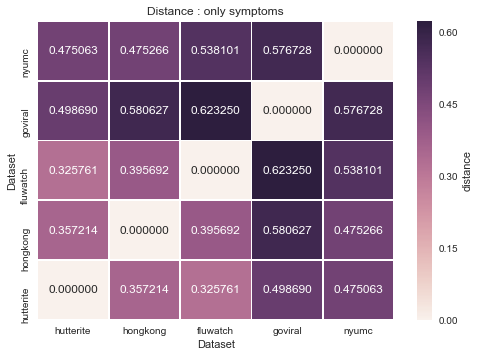

In [85]:
positive_distances = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  positive_distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : only symptoms')

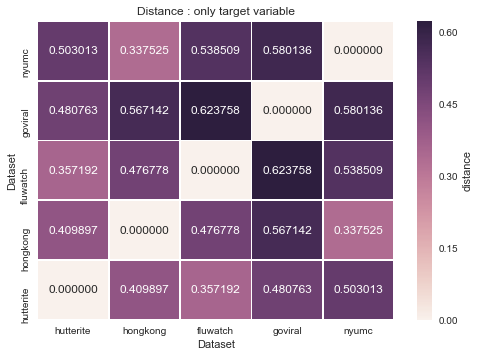

In [86]:
general_distance = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : only target variable')

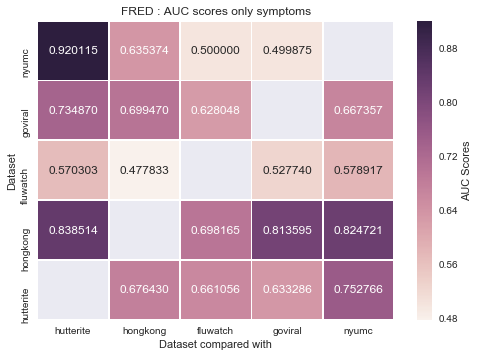

In [92]:
nyumc = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'], 
                     results, 
                     'Dataset',
                     ['hutterite','hongkong','fluwatch','goviral','nyumc'],'AUC Scores','FRED : AUC scores only symptoms')

In [88]:
results

defaultdict(None,
            {'fluwatch': defaultdict(None,
                         {'goviral': 0.52773976768229636,
                          'hongkong': 0.47783251231527102,
                          'hutterite': 0.57030347260232317,
                          'nyumc': 0.57891656023839921}),
             'goviral': defaultdict(None,
                         {'fluwatch': 0.62804813997809084,
                          'hongkong': 0.699470280166269,
                          'hutterite': 0.7348699710379808,
                          'nyumc': 0.66735695313555121}),
             'hongkong': defaultdict(None,
                         {'fluwatch': 0.69816451393609791,
                          'goviral': 0.81359513909748682,
                          'hutterite': 0.83851378346764605,
                          'nyumc': 0.82472123998217617}),
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.66105592394631385,
                          'goviral': 0.633285576